In [239]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astroduet.bbmag import bb_abmag_fluence
from astroduet.image_utils import construct_image, find, ap_phot, run_daophot
from astroduet.config import Telescope
from astroduet.background import background_pixel_rate
from astroduet.utils import duet_abmag_to_fluence
from astropy.table import Table

from astroduet.imsim_limmags import imsim_suite
from astropy.io import fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [221]:
duet = Telescope()
frame = np.array([30,30])
reff = 16.5 *u.arcsec
gal_sizex = 2*reff/duet.pixel/frame[0]
gal_startx = 0.5-gal_sizex
gal_sizey = 2*reff/duet.pixel/frame[1]
gal_starty = 0.5*-gal_sizey

In [222]:
gal_startx

<Quantity 0.328125>

In [240]:
imsim_suite(sfb=[20,21],nmags=5,nsrc=2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_ref.fits'

In [319]:
hdu_ref = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_reference.fits')
hdu_im = fits.open('../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_21.0_zodi-low_src-20.80.fits')

In [285]:
hdu_im.info()

Filename: ../astroduet/data/image_library/tel_best/gal_spiral/zodi_low/duet1/best_duet1_spiral_20.0_zodi-low_src-20.10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      13   ()      
  1                1 ImageHDU        11   (30, 30)   float64   
  2                1 ImageHDU        11   (30, 30)   float64   


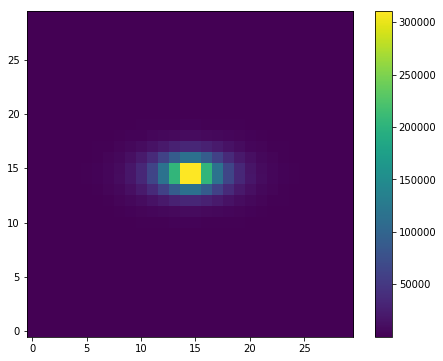

In [320]:
plt.figure(figsize=[8,6])
plt.imshow(hdu_ref[3].data, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

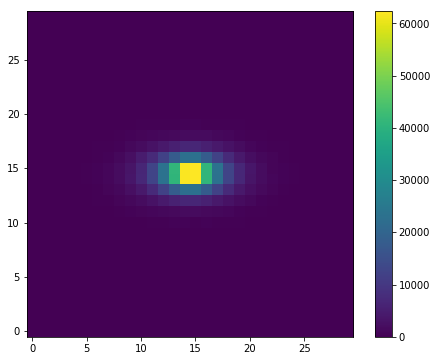

In [321]:
plt.figure(figsize=[8,6])
plt.imshow(hdu_im[2].data, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

In [322]:
image_rate = hdu_im[1].data / hdu_im[1].header['EXPTIME'] *u.ph / u.s
ref_image_rate = hdu_ref[2].data / hdu_ref[2].header['EXPTIME'] *u.ph / u.s

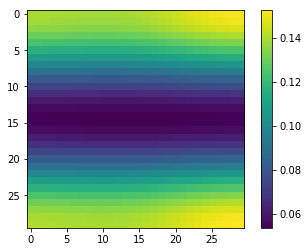

In [324]:
# Part 3, make a difference image

from astroduet.diff_image import py_zogy
from astroduet.image_utils import estimate_background

# Make a 2D array containing the PSF (oversample then bin up for more accurate PSF)

oversample = 5
pixel_size_init = duet.pixel / oversample

psf_model = duet.psf_model(pixel_size=pixel_size_init, x_size=25, y_size=25)

psf_os = psf_model.array

#psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

# Use ZOGY algorithm to create difference image
image_bkg, image_bkg_rms_median = estimate_background(image_rate)
ref_bkg, ref_bkg_rms_median = estimate_background(ref_image_rate)
image_rate_bkgsub, ref_rate_bkgsub = image_rate - image_bkg, ref_image_rate - ref_bkg

s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.1, 0.01 # Astrometric uncertainty (sigma)
diff_image, d_psf, s_corr = py_zogy(image_rate_bkgsub.value,
                                    ref_rate_bkgsub.value,
                                    psf_array,psf_array,
                                    s_n.value,s_r.value,
                                    sn.value,sr.value,dx,dy)

diff_image *= image_rate_bkgsub.unit
plt.imshow(image_bkg.value)
plt.colorbar()
plt.show()

In [300]:
hdu_im[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   30                                                  
NAXIS2  =                   30                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
SRC_POSX=    15.70730214834521 / X-position of source in image (pixels)         
SRC_POSY=    18.26223581581893 / Y-position of source in image (pixels)         
BUNIT   = 'ph      '                                                            
EXPTIME =                300.0 / Exposure time (s)                              

In [276]:
np.linspace(sfb - np.floor(0.5*nmags)*0.1, sfb + np.floor(0.5*nmags)*0.1, num=nmags, endpoint=True)

array([19.7 , 19.82, 19.94, 20.06, 20.18, 20.3 ])

In [273]:
np.floor(20.5)

20.0